Performing multitaper spectral analysis to _C. elegans_ calcium data.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from data._utils import pick_worm, load_dataset

Both the periodogram and the spectrogram are used for spectral analysis of a signal. They each provide a way to visualize the frequency content of a signal, but they are used in slightly different ways and provide different types of information.

1. **Periodogram**: The periodogram is a basic tool used in signal processing for estimating the Power Spectral Density (PSD) of a signal. The PSD is a measure of the signal's power intensity in the frequency domain. The periodogram is computed by taking the Fourier Transform of the signal, which converts the signal from the time domain to the frequency domain, and then taking the magnitude squared of the result. This provides a plot of the signal's power (on the y-axis) as a function of frequency (on the x-axis). The periodogram assumes that the signal is stationary, which means that its statistical properties do not change over time.

2. **Spectrogram**: The spectrogram, on the other hand, is a visualization tool that depicts how the spectral density of a signal varies over time. In other words, it provides a time-frequency representation of the signal. It's essentially a series of periodograms, computed for successive time windows of the signal, and then plotted as a 2D image. The x-axis represents time, the y-axis represents frequency, and the color or intensity represents the power or amplitude at each time and frequency. The spectrogram allows you to see how the frequency content of the signal changes over time, which makes it useful for analyzing non-stationary signals.

In summary, while a periodogram provides a frequency-based view of a signal, a spectrogram provides a time-frequency view that shows how the spectral content of the signal changes over time.

In [92]:
# My data
Kato2015 = load_dataset("Kato2015")
single_worm_dataset = pick_worm(Kato2015, 0)

calcium_data = single_worm_dataset["calcium_data"].numpy()
print(
    "shape of calcium data:", calcium_data.shape, "= (time, neurons)"
)  #  time x neurons

# sampling rate
dt = single_worm_dataset["resample_median_dt"]
sampling_rate = 1 / dt

shape of calcium data: (719, 302) = (time, neurons)


# Using `scipy.signal.spectrogram` directly

No, `scipy.signal.spectrogram` does not implement the multitaper method for computing spectrograms. It uses Short Time Fourier Transform (STFT) to compute spectrograms, which essentially involves applying a Fourier Transform on short, overlapping segments of the signal.

While the multitaper method and STFT are both methods to compute the spectrogram, they work in fundamentally different ways. The multitaper method uses multiple window functions (the tapers) to reduce variance in the spectrogram, at the cost of reducing frequency resolution. On the other hand, STFT uses a single window function (although the choice of window can vary) and can maintain frequency resolution, but it may have higher variance.

chape of calcium data: (100, 1200) = (neurons, time)
chape of calcium data: (302, 719) = (neurons, time)


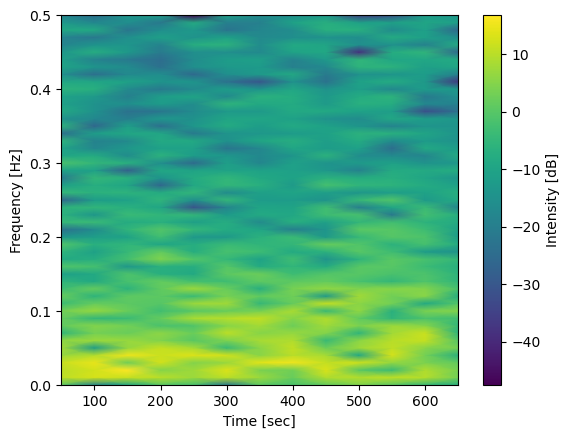

In [85]:
# Assuming calcium_data is your data matrix of shape (num_neurons, max_timesteps)

# using a random example here
num_neurons = 100
max_timesteps = (
    1200  # this would correspond to a 600-second recording at a 4Hz sampling rate
)
calcium_data = np.random.rand(num_neurons, max_timesteps)
print(
    "chape of calcium data:", calcium_data.shape, "= (neurons, time)"
)  # neurons x time

# using my actual data instead
calcium_data = single_worm_dataset["calcium_data"].numpy().T
print(
    "chape of calcium data:", calcium_data.shape, "= (neurons, time)"
)  # neurons x time

# Choose one neuron's data to analyze
neuron_data = calcium_data[8, :]

# Parameters for the spectrogram
fs = sampling_rate  # Sampling frequency
nperseg = 100  # Length of each segment
noverlap = 50  # Number of points to overlap between segments

# Compute the spectrogram
frequencies, times, Sxx = signal.spectrogram(
    neuron_data, fs, nperseg=nperseg, noverlap=noverlap
)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label="Intensity [dB]")
plt.show()


# Building the mutitaper method using `scipy.signal.spectogram`.

The multitaper method is a bit more complex than applying the standard Fourier Transform as it uses multiple "tapers", or window functions, to the signal before applying the Fourier Transform. The multiple results are then combined in a way that reduces the variance of the final spectrogram.

The `scipy` library does not natively support the multitaper method for spectrogram calculation, as it requires some additional steps beyond what is implemented in the `scipy.signal.spectrogram` function. The `scipy.signal.spectrogram` function computes the spectrogram using the Short-Time Fourier Transform (STFT), which applies a Fourier Transform to overlapping segments of the signal.

To implement the multitaper method in Python without relying on additional packages like `spectrum` or `mne`, you would need to:

1. Compute the set of tapers to use. The most common choice is the DPSS (Discrete Prolate Spheroidal Sequences), which can be computed using the `scipy.signal.windows.dpss` function.
2. For each taper, multiply it element-wise with the signal. This gives a windowed version of the signal.
3. Apply the Fourier Transform (for example using `numpy.fft.fft`) to each windowed signal.
4. Average the resulting spectra.

Here is a rough example of how you might implement this:


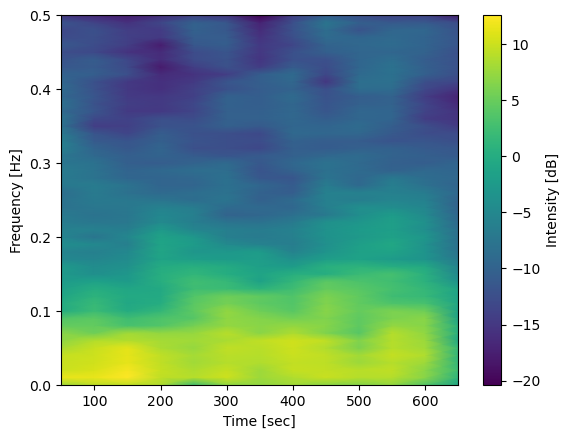

In [86]:
# Custom written multitaper method
def multitaper_spectrogram(y, fs, nperseg, noverlap, NW):
    # Compute the tapers
    tapers = signal.windows.dpss(nperseg, NW, Kmax=2 * NW - 1)

    # Pre-allocate the spectrogram array
    f, t, Sxx = signal.spectrogram(
        y, fs, window=tapers[0], nperseg=nperseg, noverlap=noverlap
    )
    Sxx_multi = np.zeros((len(tapers), len(f), len(t)))

    # Compute the spectrogram for each taper and average them
    for i, taper in enumerate(tapers):
        f, t, Sxx_multi[i] = signal.spectrogram(
            y, fs, window=taper, nperseg=nperseg, noverlap=noverlap
        )
    Sxx = Sxx_multi.mean(axis=0)

    return f, t, Sxx


# Now you can use the function on your data
y = calcium_data[8, :]
fs = sampling_rate
nperseg = 100
noverlap = 50
NW = 4
f, t, Sxx = multitaper_spectrogram(y, fs, nperseg, noverlap, NW)

# Plot the spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label="Intensity [dB]")
plt.show()

Note that this is a very basic implementation and may not cover all cases. In practice, you would probably want to add more functionality, such as choosing the number of tapers, handling different data types, etc. Furthermore, you would need to decide how to choose the `NW` parameter, which influences the balance between frequency resolution and variance in the spectrogram.

This approach is quite manual and does not offer the same convenience as using a library function, but it gives you more control over the computation and can be a good learning exercise.